<div style="text-align: center;">
    <h1 style="font-weight: bold;">Netflix Project </h1>
</div>

# **Introduction**

This project aims to analyze a [Netflix dataset from Kaggle](https://www.kaggle.com/datasets/shivamb/netflix-shows/data), which includes details about movies and TV shows available on Netflix. 

`About this Dataset`: Netflix is one of the most popular media and video streaming platforms. They have over 8000 movies or tv shows available on their platform, as of mid-2021, they have over 200M Subscribers globally. This tabular dataset consists of listings of all the movies and tv shows available on Netflix, along with details such as - cast, directors, ratings, release year, duration, etc.

The project involves :
* **Data wrangling** : cleaning the data
* **Exploratory Data Analysis (EDA)**
* **Time series analysis**
* **Clustering** : to identify patterns and group similar content

By the end of the project, I will present insights into Netflix’s content, uncovering key trends and relationships within the data 

# 1. Import libraries and Load the dataset

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [4]:
# Load the dataset
df = pd.read_csv('data_resources/netflix_titles.csv')

# Show basic info
df.info()
df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


# 2. Data cleaning

# Handling missing values

In [5]:
# Check for missing values
df.isnull().sum()

show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64

In [6]:
# Fill missing values with strings
df['director'] = df['director'].fillna('Unknown')
df['cast'] = df['cast'].fillna('Unknown')
df['country'] = df['country'].fillna('Unknown')
df['rating'] = df['rating'].fillna('Unknown')


# Fill missing values in 'date_added' with the mode
# mode is the value that appears most frequently in a dataset
df['date_added'] = df['date_added'].fillna(df['date_added'].mode()[0])

# Drop rows where duration' have null values
df = df.dropna(subset=['duration'])

# Convert date_added

We convert date_added values to the same format

In [7]:
# Define a function to handle different date formats
def parse_date(date):
    date_formats = [
        '%B %d, %Y',       # 'December 15, 2018'
        '%d-%b-%y',        # '15-Dec-18'
        '%d-%m-%Y',        # '15-12-2018'
        '%b %d, %Y'        # 'Dec 15, 2018'
    ]
    
    for fmt in date_formats:
        try:
            return pd.to_datetime(date, format=fmt)
        except (ValueError, TypeError):
            continue  # If it doesn't match the format, try the next one
    
    return pd.to_datetime(date, errors='coerce')  # Fallback if no format matches

# Apply the function to the 'date_added' column
df['date_added'] = df['date_added'].apply(parse_date)

# Check if there are any remaining invalid dates (NaT values)
print("Number of NaT values in 'date_added' column:", df['date_added'].isna().sum())

Number of NaT values in 'date_added' column: 0


We check our cleaned dataset

In [8]:
# Verify if null values are removed
df.isnull().sum()

show_id         0
type            0
title           0
director        0
cast            0
country         0
date_added      0
release_year    0
rating          0
duration        0
listed_in       0
description     0
dtype: int64

In [9]:
df.head(5)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,Unknown,United States,2021-09-25,2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,Unknown,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",Unknown,2021-09-24,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,Unknown,Unknown,Unknown,2021-09-24,2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,Unknown,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [10]:
print(df.shape) #8804 rows and 12 columns in total

(8804, 12)


# 3. Exploratory Data Analysis (EDA)

**a) How is the distribution of movies and tv shows?**

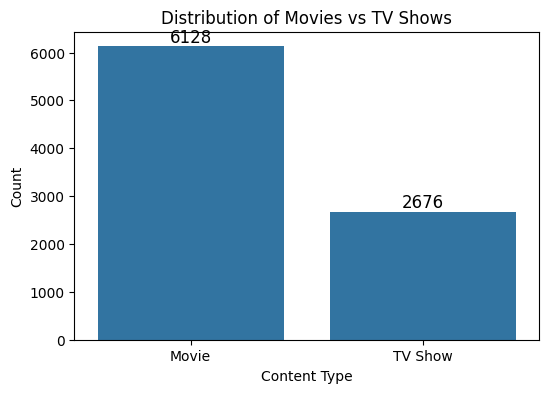

In [11]:
# Plot the distribution of Movies vs TV Shows
plt.figure(figsize=(6, 4))
ax = sns.countplot(data=df, x='type')

# Add labels on top of the bars
for p in ax.patches:
    # Get the height of each bar (number of counts)
    height = p.get_height()
    # Add the label (number) above each bar
    ax.text(
        p.get_x() + p.get_width() / 2,  # X position (middle of the bar)
        height + 1,  # Y position (slightly above the bar)
        int(height),  # Value to display
        ha='center',  # Horizontal alignment
        va='bottom',  # Vertical alignment
        fontsize=12  # Font size for the label
    )

# Set plot title and labels
plt.title('Distribution of Movies vs TV Shows')
plt.xlabel('Content Type')
plt.ylabel('Count')

# Show the plot
plt.show()

This is consistent because 6128+2676 = 8804 which corresponds to our number of lines

**b) What are the top 10 content genres?**

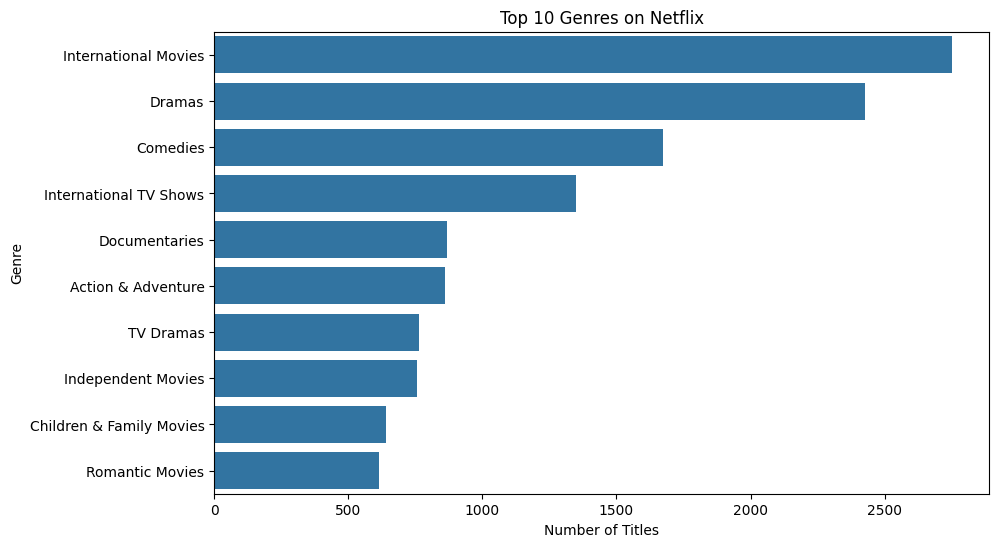

In [12]:
# Split 'listed_in' by commas and count unique genres 
genres = df['listed_in'].str.split(', ').explode().str.strip()
top10_genres = genres.value_counts().head(10)

# Bar chart
plt.figure(figsize=(10,6))
sns.barplot(x=top10_genres.values, y=top10_genres.index)
plt.title('Top 10 Genres on Netflix')
plt.xlabel('Number of Titles')
plt.ylabel('Genre')
plt.show()

**c) Which countries have produced the most content?**

In [13]:
# Split each string in the 'country' column by commas and explode it into separate rows
countries_series = df['country'].str.split(',').explode().str.strip()

# top 10
country_counts = countries_series.value_counts().head(10)

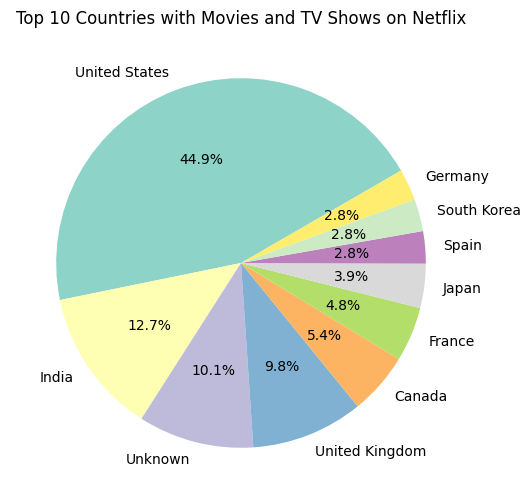

In [14]:
#Create a pie chart to represent the number of Movies and TV Shows per country
plt.figure(figsize=(10, 6))
country_counts.plot(kind='pie', autopct='%1.1f%%', startangle=30, cmap='Set3')
plt.title("Top 10 Countries with Movies and TV Shows on Netflix")
plt.ylabel('')
plt.show()

We note that a large part of the dataset (10.1%) has missing values. We can also see that the USA is over-represented among the countries that produce content, accounting for almost half of our values (44.9%).

# 4. Times Series Analysis

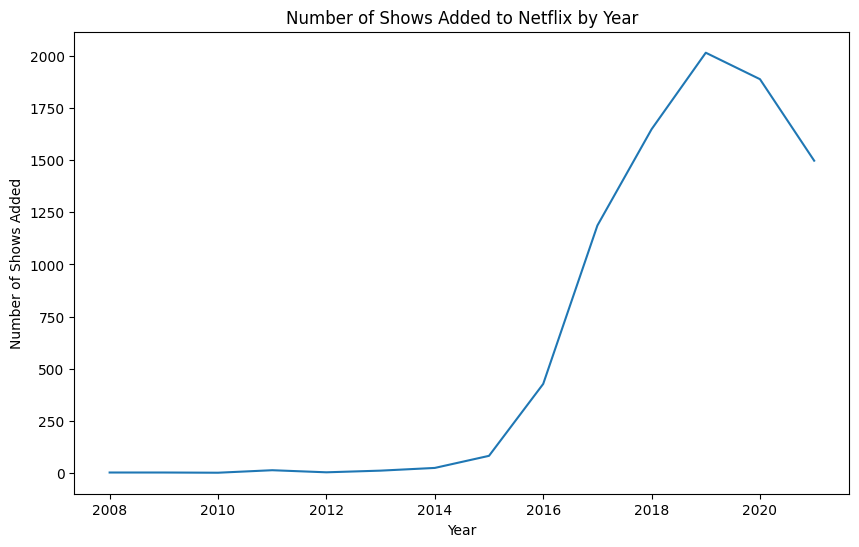

In [15]:
# Group by the year and count the shows added each year
df['year_added'] = df['date_added'].dt.year
df['year_added'].value_counts().sort_index().plot(figsize=(10, 6))
plt.title('Number of Shows Added to Netflix by Year')
plt.xlabel('Year')
plt.ylabel('Number of Shows Added')
plt.show()

We can see that the amount of content added to Netflix soared since 2016.

<span style="font-size: 11px;">Copyright © 2024 Laure Bouzerand. All rights reserved.
This notebook and its source code is protected by copyright law. You may not reproduce, distribute, or use this work without the express written permission of the copyright holder.
</span>